<a href="https://colab.research.google.com/github/DataScienceUB/DeepLearningMaster2019/blob/master/7.%20Recurrent%20Neural%20Networks%20II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ``seq2seq`` architecture

Source: https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py 

The objective of this code is to train a RNN for adding a sequence of integers. In this case we must process all the sequence in order to produce a result. We will use a ``keras`` implementation of the ``seq2seq`` architecure, originally proposed by Sutskever, Vinyals and Le in 2014. 

The architecture diagram from their paper is:

<center>
<img src="https://github.com/DataScienceUB/DeepLearningMaster2019/blob/master/images/seq2seq.png?raw=1" alt="" style="width: 800px;"/> 
Source: https://arxiv.org/abs/1409.3215
</center>

Rectangles are recurrent layers. Encoder receives ``[A, B, C]`` sequence as inputs. We don't care about encoder outputs, only about the hidden state it accumulates while reading the sequence. 

After input sequence ends, encoder passes its final state to decoder, which receives ``[<EOS>, W, X, Y, Z]`` and is trained to output ``[W, X, Y, Z, <EOS>]``. 

Sequence-to-sequence, or *Seq2Seq*, is a paradigm made up of two recurrent networks: an *encoder* which takes the model's input sequence as input and encodes it into a fixed-size *context vector*, and a *decoder*, which uses the context vector from above as a *seed* from which to generate an output sequence.

> For this reason, Seq2Seq models are often referred to as *encoder-decoder* models.

The encoder network's job is to read the input sequence and generate a fixed-dimensional context vector $C$ for the sequence. 

To do so, the encoder will use a recurrent neural network cell -- usually an LSTM -- to read the input tokens one at a time. The final hidden state of the cell will then become $C$. 

However, because it's so difficult to compress an arbitrary-length sequence into a single fixed-size vector, the encoder will usually consist of *stacked* LSTMs. The *final* layer's LSTM hidden state will be used as $C$.

The decoder is also an LSTM network, but its usage is a little more complex than the encoder network. Essentially, we'd like to use it as a language model that's "aware" of the words that it's generated so far *and* of the input. 

To that end, we'll keep the "stacked" LSTM architecture from the encoder, but we'll initialize the hidden state of our first layer with the context vector from above; the decoder will literally use the context of the input to generate an output.

When both input sequences and output sequences have the same length, you can implement such models simply with one Keras LSTM or GRU layer (or stack thereof).

One caveat of this approach is that it assumes that it is possible to generate ``target[...t]`` given ``input[...t]``. That works in some cases but does not work for most use cases. In the general case, information about the entire input sequence is necessary in order to start generating the target sequence.



In [1]:
'''An implementation of sequence to sequence learning for performing addition
Input: "535+61 "
Output:"596 "
Padding is handled by using a repeated space character
'''

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import numpy as np
from six.moves import range


class CharacterTable(object):
  
    """Given a set of characters:
    + Encode them to a one hot integer representation
    + Decode the one hot integer representation to their character output
    + Decode a vector of probabilities to their character output
    """
    
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars        = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)


class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
REVERSE = True


# Maximum length of input is 'int + int' (e.g., '345+678'). 
# Maximum length of int is DIGITS.
MAXLEN = DIGITS + 1 + DIGITS

# All the numbers, plus sign and space for padding.
chars = '0123456789+ '
ctable = CharacterTable(chars)

questions = []
expected = []
seen = set()
print('Generating data...','\n')

while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                    for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    questions.append(query)
    expected.append(ans)
print('Total questions: ', len(questions),'\n')

for i in range(10):
  n = np.random.randint(len(questions))
  print('Random example :', questions[n], expected[n])

Generating data... 

Total questions:  50000 

Random example : 755+38  793 
Random example : 728+856 1584
Random example : 392+85  477 
Random example : 27+869  896 
Random example : 89+258  347 
Random example : 452+983 1435
Random example : 678+77  755 
Random example : 859+794 1653
Random example : 29+26   55  
Random example : 10+286  296 


In [2]:
print('One hot encoding... \n')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)


# Shuffle (x, y) 
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data  : '  , end="")
print(x_train.shape, end="")
print(y_train.shape)

print('Validation Data: ', end="")
print(x_val.shape, end="")
print(y_val.shape)

One hot encoding... 

Training Data  : (45000, 7, 12)(45000, 4, 12)
Validation Data: (5000, 7, 12)(5000, 4, 12)


We will use some utility layers:
+ `RepeatVector` : it repeats its input `n` times.

```
   model = Sequential()
   model.add(Dense(32, input_dim=32))
   # now: model.output_shape == (None, 32)

   model.add(RepeatVector(3))
   # now: model.output_shape == (None, 3, 32)
```

+ `TimeDistributed`: In keras - while building a sequential model - usually the second dimension (one after sample dimension) - is related to a time dimension. This layer applies a layer to every temporal slice of an input.
The input should be at least 3D, and the dimension of index one will be considered to be the temporal dimension.
Consider a batch of 32 samples, where each sample is a sequence of 10 vectors of 16 dimensions. The batch input shape of the layer is then (32, 10, 16), and the input_shape, not including the samples dimension, is (10, 16).
You can then use TimeDistributed to apply a Dense layer to each of the 10 time steps, independently:

```
    # as the first layer in a model
    model = Sequential()
    model.add(TimeDistributed(Dense(8), input_shape=(10, 16)))
    # now model.output_shape == (None, 10, 8)
```

In [3]:
# Try replacing GRU, or SimpleRNN.

# keras.layers.LSTM(units, 
#                   activation='tanh', 
#                   use_bias=True, 
#                   recurrent_initializer='orthogonal', 
#                   bias_initializer='zeros', 
#                   ...
#                   return_sequences=False, 
#                   return_state=False, 
#                   stateful=False)


RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()

# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# you can use input_shape=(None, num_feature).
# Returns the last output in the output sequence
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))

# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))

# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

# Train the model each generation and show predictions against the validation
# dataset.
for iteration in range(1, 200):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(10):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q, end=' ')
        print('T', correct, end=' ')
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=' ')
        else:
            print(colors.fail + '☒' + colors.close, end=' ')
        print(guess)

Build model...
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               72192     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 4, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 12)             1548      
_________________________________________________________________
activation (Activation)      (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________

------------------------------------------------

## The general case: canonical sequence-to-sequence

In the general case, input sequences and output sequences have different lengths (e.g. machine translation) and the entire input sequence is required in order to start predicting the target. Here's how it works:

+ A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.
+ Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next elements of the target sequence, given previous elements of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called **teacher forcing** in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate ``targets[t+1...]`` given ``targets[...t]``, conditioned on the input sequence.

In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

+ Encode the input sequence into state vectors.
+ Start with a target sequence of size 1 (just the start-of-sequence element).
+ Feed the state vectors and 1-char target sequence to the decoder to produce predictions for the next element.
+ Sample the next element using these predictions (we simply use ``argmax``).
+ Append the sampled element to the target sequence
+ Repeat until we generate the end-of-sequence element or we hit the character limit.

For our example implementation, we will use a dataset of pairs of English sentences and their Catalan translation (which can be downloaded from [manythings.org/anki](http://manythings.org/anki)). 

We will implement a **character-level sequence-to-sequence model**, processing the input character-by-character and generating the output character-by-character. Another option would be a word-level model, which tends to be more common for machine translation. 

Here's a summary of our process:

1) Turn the sentences into 3 Numpy arrays, ``encoder_input_data``, ``decoder_input_data``, ``decoder_target_data``:
 + ``encoder_input_data`` is a 3D array of shape ``(num_pairs, max_english_sentence_length, num_english_characters)`` containing a one-hot vectorization of the English sentences.
 + ``decoder_input_data`` is a 3D array of shape ``(num_pairs, max_cat_sentence_length, num_cat_characters)`` containg a one-hot vectorization of the Catalan sentences.
 + ``decoder_target_data`` is the same as ``decoder_input_data`` but offset by one timestep. ``decoder_target_data[:, t, :]`` will be the same as ``decoder_input_data[:, t + 1, :]``.

2) Train a basic LSTM-based ``Seq2Seq`` model to predict `decoder_target_data`` given ``encoder_input_data`` and ``decoder_input_data``. Our model uses teacher forcing.

3) Decode some sentences to check that the model is working (i.e. turn samples from `encoder_input_data` into corresponding samples from `decoder_target_data``).

Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.

This is our training model. It leverages three key features of Keras RNNs:

+ The ``return_state`` contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.
+ The ``inital_state`` call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.
+ The ``return_sequences`` constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np
import requests

batch_size = 64  
epochs = 100  
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  

data_path = 'https://raw.githubusercontent.com/DataScienceUB/DeepLearningMaster2019/master/data/cat.txt'

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

response = requests.get(data_path)
data = response.text

lines = data.split('\n')
print('There are',len(lines),'sequences such as ',end='')
lines[11]

In [5]:
# Vectorize the data.

for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

print('\nInput sequence: \n',encoder_input_data[0])
print('\nInput sequence first letter: \n',encoder_input_data[0][0])


Number of samples: 606
Number of unique input tokens: 68
Number of unique output tokens: 81
Max sequence length for inputs: 107
Max sequence length for outputs: 106

Input sequence: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Input sequence first letter: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
# We use `encoder_states` as initial state.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 484 samples, validate on 122 samples
Epoch 1/100
484/484 [==============================] - 5s 11ms/sample - loss: 0.9571 - val_loss: 1.4103
Epoch 2/100
484/484 [==============================] - 3s 7ms/sample - loss: 0.8035 - val_loss: 1.4036
Epoch 3/100
484/484 [==============================] - 4s 7ms/sample - loss: 0.7920 - val_loss: 1.4046
Epoch 4/100
484/484 [==============================] - 4s 7ms/sample - loss: 0.7853 - val_loss: 1.3973
Epoch 5/100
484/484 [==============================] - 4s 8ms/sample - loss: 0.7793 - val_loss: 1.3734
Epoch 6/100
484/484 [==============================] - 4s 8ms/sample - loss: 0.7743 - val_loss: 1.3512
Epoch 7/100
484/484 [==============================] - 4s 7ms/sample - loss: 0.7677 - val_loss: 1.3695
Epoch 8/100
484/484 [==============================] - 4s 7ms/sample - loss: 0.7667 - val_loss: 1.3636
Epoch 9/100
484/484 [==============================] - 4s 7ms/sample - loss: 0.7587 - val_loss: 1.3324
Epoch 10/100
484/484 [====

KeyboardInterrupt: ignored

Next step: inference mode (sampling):
+ encode input and retrieve initial decoder state
+ run one step of decoder with this initial state and a "*start of sequence*" token as target. Output will be the next target token.
+ Repeat with the current target token and current states

In [0]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

## Example

A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.

This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/

In [0]:
import tensorflow as tf
from tensorflow.contrib import rnn

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

To classify images using a recurrent neural network, we consider every image row as a sequence of pixels. 

Because MNIST image shape is $28 \times 28$ px, we will then handle 28 sequences of 28 steps for every sample.

In [0]:
# Training Parameters
learning_rate = 0.001
training_steps = 10000
batch_size = 128
display_step = 200

# Network Parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 # timesteps
num_hidden = 128 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

In [0]:
# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [0]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [0]:
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))

    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: test_data, Y: test_label}))

## Bidirectional LSTM

So  far,  we  have  focused  on  RNNs  that  look  into  the  past    to predict future values in the sequence, but not to  to make predictions based on future values by reading throught the sequence backwards. Why?

**Bi-directional  deep  neural networs**,  at each time-step, $t$,  maintain two hidden layers, one for the left-to-right propagation and another for the right-to-left  propagation (hence, consuming twice  as  much  memory  space).   

The final classification result, $\hat{y}$, is generated through combining the score results produced by both RNN hidden layers.

<img src = "./images/t9.png"  width = "600">

The equations are (arrows are for designing left-to-right and right-to-left tensors):

$$
	\overrightarrow{h}_t = f(\overrightarrow{W} x_t + \overrightarrow{V} \overrightarrow{h}_{t-1} + \overrightarrow{b})
$$
$$
	\overleftarrow{h}_t = f(\overleftarrow{W} x_t + \overleftarrow{V} \overleftarrow{h}_{t+1} + \overleftarrow{b})
$$
$$
	\hat{y}_t = g(U h_t + c) = g(U [\overrightarrow{h}_t; \overleftarrow{h}_t] + c)
$$

$[\overrightarrow{h}_t; \overleftarrow{h}_t]$ summarizes the past and future of a single element of the sequence.

Biderectional RNNs can be stacked as usual!

We will use an `embedding` layer.

This layer turns positive integers (indexes) into dense vectors of fixed size (to be learned during training). eg. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

This layer can only be used as the first layer in a model.

The task is IMDB Movie reviews sentiment classification.

IMDB dataset contains 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. 

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

`num_words` parameter denotes the number of most frequent words to consider. Any less frequent word will appear as "0" value in the sequence data.

In [0]:
import numpy as np

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.datasets import imdb

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

## Name generation with LSTM

We are going to train RNN "character-level" language models. 

That is, we’ll give the RNN a huge chunk of text and ask it to model the probability distribution of the next character in the sequence given a sequence of previous characters. This will then allow us to generate new text one character at a time.

We will encode each character into a vector using ``1-of-k`` encoding (i.e. all zero except for a single one at the index of the character in the vocabulary), and feed them into the RNN one at a time. 

At test time, we will feed a sequence of characters into the RNN and get a distribution over what characters are likely to come next. We sample from this distribution, and feed it right back in to get the next letter. Repeat this process and you’re sampling text!

We can also play with the temperature of the Softmax during sampling. Decreasing the temperature from 1 to some lower number (e.g. 0.5) makes the RNN more confident, but also more conservative in its samples. Conversely, higher temperatures will give more diversity but at cost of more mistakes.

> Remider: **Softmax**
>$$
	P(y = j | \mathbf{x}) = \frac{\exp(\mathbf{x}^T \mathbf{w}_j)/\tau}{\sum_{k=1}^K \exp(\mathbf{x}^T \mathbf{w}_k)/\tau}
$$
> $\tau$ is called *temperature*. For high temperatures ( $ \tau \to \infty $ ), all $y$ have nearly the same probability. For a low temperature ( $ \tau \to 0^{+}$), the probability of the most probable $y$ tends to 1.

In order to process sequences of symbols with RNN we need to represent these symbols by numbers.

Let's suppose we have $|V|$ different symbols. The most simple representation is the **one-hot vector**: Represent every word as an $\mathbb{R}^{|V|\times1}$ vector with all $0$s and one $1$ at the index of that word in the sorted english language. Symbol vectors in this type of encoding would appear as the following:

$$w^{s_1} = \left[ \begin{array}{c} 1 \\ 0 \\ 0 \\ \vdots \\ 0 \end{array} \right], w^{s_2} = \left[ \begin{array}{c} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{array} \right], w^{s_3} = \left[ \begin{array}{c} 0 \\ 0 \\ 1 \\ \vdots \\ 0 \end{array} \right], \cdots 
w^{s_{|V|}} = \left[ \begin{array}{c} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{array} \right] $$

We represent each symbol as a completely independent entity. This symbol representation does not give us directly any notion of similarity.

To train our model we need text to learn from a large dataset of names. Fortunately we don’t need any labels to train a language model, just raw text.

Places names: You can download 52,700 Catalan names from a dataset available on http://territori.gencat.cat/ca/01_departament/11_normativa_i_documentacio/03_documentacio/02_territori_i_mobilitat/cartografia/nomenclator_oficial_de_toponimia_de_catalunya/

In [0]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

import codecs
f = codecs.open('data/NombresMujerBarcelona.txt', "r", "utf-8")
#f = codecs.open('data/toponims.txt', "r", "utf-8")
string = f.read()
string.encode('utf-8')
text = string.lower()

# text = text.replace("\n", " ")
    
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 20
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

corpus length: 47527
total chars: 30
nb sequences: 15836
Vectorization...


In [0]:
# build the model

print('Build model...')
model = Sequential()
model.add(LSTM(64, 
#               return_sequences=True,
               recurrent_dropout=0.2, 
               dropout=0.2, 
               input_shape=(maxlen, len(chars))))
#model.add(LSTM(64, 
#               recurrent_dropout=0.2, 
#               dropout=0.2))
model.add(Dense(len(chars)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. 

This process is repeated for as long as we want to predict new characters

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=256, epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence.replace("\n", " ") + '"')
        
    for diversity in [0.5, 1.0]:
        print()
        print('----- diversity:', diversity)
        for i in range(50):
            
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
15836/15836 [==============================] - 7s 439us/step - loss: 2.9351
----- Generating with seed: "mparo amy ana ana al"

----- diversity: 0.5
elewela
aaqa
maria marina
siisa ioja ilasela imari

----- diversity: 1.0
i ebmojda
vc cra

agdga teqkay esjlotcifa
a
gptus


--------------------------------------------------
Iteration 2
Epoch 1/1
15836/15836 [==============================] - 7s 434us/step - loss: 2.7172
----- Generating with seed: "a ione ionela ionica"

----- diversity: 0.5

maria haria maria carela
maria alia
maria caria c

----- diversity: 1.0
i y
hiatakzaawamqçña
jbaz
gapphria dlkiy exess
jvr

--------------------------------------------------
Iteration 3
Epoch 1/1
15836/15836 [==============================] - 6s 409us/step - loss: 2.6507
----- Generating with seed: "onisa leonor leonor "

----- diversity: 0.5
alvevevia
ijjafila
çoa
xiodtk
saria clolil
agcexa 

----- diversity: 1.0
urelila pj

KeyboardInterrupt: 

In [0]:
'sarsa' in text

False

In the case of places, after several hours you can generate names such as:

+ Alzinetes, torrent de les
+ Alzinetes, vall de les
+ **Alzinó, Mas d'**
+ Alzinosa, collada de l'
+ Alzinosa, font de l'

-

+ Benavent, roc de
+ Benaviure, Cal
+ **Benca**
+ Bendiners, pla de
+ Benedi, roc del

-

+ Fiola, la
+ Fiola, puig de la
+ **Fiper, Granja del**
+ Firassa, Finca
+ Firell

-

+ Regueret, lo
+ Regueret, lo
+ **Regueró**
+ Reguerols, els
+ Reguerons, els

-

+ Vallverdú, Mas de
+ Vallverdú, serrat de
+ **Vallvicamanyà**
+ Vallvidrera
+ Vallvidrera, riera de

-

+ Terraubella, Corral de
+ Terraubes
+ **Terravanca**
+ Terrer Nou, Can
+ Terrer Roig, lo

where names in **bold** are generated and other names are the nearest neighbours (in the training dataset) of the generated name.

## Exercise

The task here will be to be able to predict values for a timeseries: the history of 2 million minutes of a household's power consumption. We are going to use a **multi-layered LSTM** recurrent neural network to predict the last value of a sequence of values. Put another way, given 49 timesteps of consumption, what will be the 50th value?

The initial file contains several different pieces of data. We will here focus on a single value : a house's Global_active_power history, minute by minute for almost 4 years. This means roughly 2 million points. 

Notes:

+ Neural networks usually learn way better when data is pre-processed. However regarding time-series we do not want the network to learn on data too far from the real world. So here we'll keep it simple and simply center the data to have a 0 mean.

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import csv
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import zipfile 

np.random.seed(1234)

def data_power_consumption(path_to_dataset,
                           sequence_length=50,
                           ratio=1.0):

    max_values = ratio * 2049280
    
    zfile = zipfile.ZipFile(path_to_dataset)
    zfile.extractall("data/")
    
    with open('data/household_power_consumption.txt') as f:
        data = csv.reader(f, delimiter=";")
        power = []
        nb_of_values = 0
        for line in data:
            try:
                power.append(float(line[2]))
                nb_of_values += 1
            except ValueError:
                pass
            # 2049280.0 is the total number of valid values, i.e. ratio = 1.0
            if nb_of_values >= max_values:
                break

    print("Data loaded from csv. Formatting...")

    result = []
    for index in range(len(power) - sequence_length):
        result.append(power[index: index + sequence_length])
    result = np.array(result)  # shape (2049230, 50)

    result_mean = result.mean()
    result -= result_mean
    print("Shift : ", result_mean)
    print("Data  : ", result.shape)

    row = int(round(0.9 * result.shape[0]))
    train = result[:row, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = result[row:, :-1]
    y_test = result[row:, -1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return [X_train, y_train, X_test, y_test]

global_start_time = time.time()
ratio = 0.5
sequence_length = 50
path_to_dataset = 'data/household_power_consumption.zip'


print('Loading data... ')
X_train, y_train, X_test, y_test = data_power_consumption(
            path_to_dataset, sequence_length, ratio)

print('\nData Loaded.')

Loading data... 
Data loaded from csv. Formatting...
Shift :  1.1030964434554305
Data  :  (1024590, 50)

Data Loaded.


In [0]:
X_train=X_train[:20000,:,:]
y_train=y_train[:20000]
X_test=X_test[:10000]
y_test=y_test[:10000]

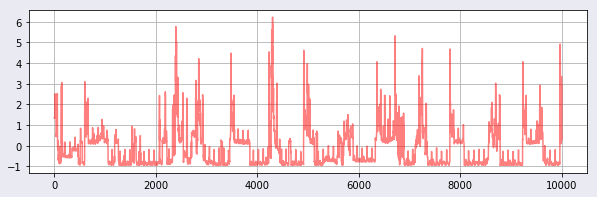

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, 'r-', alpha=0.5)
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()

In [0]:
model = Sequential()    




# your model here




start = time.time()
model.compile(loss="mse", optimizer="rmsprop")
print("Compilation Time : ", time.time() - start)

In [0]:
# change epochs, batch_size...


epochs = 1
model.fit(X_train, y_train,
          batch_size=10, 
          nb_epoch=epochs, 
          validation_split=0.05)
predicted = model.predict(X_test)
predicted = np.reshape(predicted, (predicted.size,))

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test[250:450], 'r')
plt.plot(predicted[250:450], 'g')
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, 'r', alpha=0.5)
plt.plot(predicted, 'g', alpha=0.5)
plt.gcf().set_size_inches((10,3))
fig.set_facecolor('#EAEAF2')
plt.grid(True)
plt.show()